<a href="https://colab.research.google.com/github/dsirtioglu/python/blob/dsirtioglu-RR/RR_NL_Energy_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries


In [1]:
import pandas as pd
import numpy as np
import copy

import matplotlib
from matplotlib import pyplot as plt

In [2]:
!pip install cbsodata
import cbsodata

# (Obs) Energy consumption exploration

https://bkaankuguoglu.medium.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b

https://thecleverprogrammer.com/2021/01/23/energy-consumption-prediction-with-machine-learning/ 


Production data sourced from CBS Open Data Stat Line (https://opendata.cbs.nl/statline/portal.html?_la=en&_catalog=CBS&tableId=84575ENG&_theme=1029)

In [3]:
url_nl_production = 'https://raw.githubusercontent.com/dsirtioglu/python/main/NL%20Energy%20Production_all.csv'

nl_production = pd.read_csv(url_nl_production, sep = ';')
nl_production = nl_production.set_index('ID')
nl_production.tail(20)

,Periods,GrossProduction_1,OwnConsumptionForElectrProduction_2,NetProductionTotal_3,NuclearEnergy_4,FuelsTotal_5,Coal_6,OilProducts_7,NaturalGas_8,Biomass_9,OtherFuelsNonRenewable_10,HydroPower_11,WindEnergyTotal_12,WindEnergyOnShore_13,WindEnergyOffShore_14,SolarPhotovoltaic_15,OtherSources_16,ImportsTotal_17,Belgium_18,Denmark_19,Germany_20,UnitedKingdom_21,Norway_22,ExportsTotal_23,Belgium_24,Denmark_25,Germany_26,UnitedKingdom_27,Norway_28,DistributionLosses_29,NetConsumptionCalculated_30
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
793,2019KW04,32986,976,32010,1062,26763,5889,416,18307,1756,395,21,3527,2452,1075.0,523,113,4685,766,461.0,2972,68.0,417.0,5354,1821,550.0,944,1510.0,530.0,1343,29998
794,2019JJ00,121062,3490,117572,3700,96460,19266,1385,69172,5060,1577,74,11508,7935,3573.0,5336,493,20403,4528,619.0,12238,385.0,2634.0,19548,6991,671.0,4398,6148.0,1340.0,5059,113368
795,2020MM01,11534,305,11228,361,9186,928,148,7467,504,140,11,1515,1098,417.0,116,40,1746,57,463.0,921,47.0,260.0,2002,987,2.0,586,422.0,6.0,473,10500
796,2020MM02,10304,280,10023,330,7543,843,146,5848,578,128,2,1899,1477,423.0,210,39,1669,205,372.0,765,46.0,282.0,1508,500,46.0,478,476.0,8.0,424,9761
797,2020MM03,9959,290,9669,360,7192,923,140,5314,699,116,6,1451,1081,370.0,619,41,2029,341,352.0,843,14.0,479.0,1764,466,49.0,655,574.0,20.0,436,9497
798,2020KW01,31796,875,30920,1050,23922,2694,433,18628,1782,384,19,4865,3656,1209.0,944,120,5444,602,1186.0,2528,107.0,1021.0,5274,1953,96.0,1720,1471.0,33.0,1332,29759
799,2020MM04,8289,262,8027,347,5785,473,105,4516,548,142,7,817,597,221.0,1032,40,2029,589,301.0,640,42.0,457.0,1508,255,78.0,663,490.0,22.0,394,8154
800,2020MM05,9476,275,9201,311,6759,502,78,5371,649,158,4,790,581,208.0,1299,38,1899,843,195.0,398,56.0,407.0,2244,264,159.0,1345,450.0,26.0,395,8461
801,2020MM06,9139,245,8893,156,6788,390,96,5654,509,140,2,764,513,251.0,1156,26,1353,330,43.0,660,119.0,201.0,1386,361,229.0,535,254.0,8.0,389,8472


In [4]:
nl_production_monthly = copy.copy(nl_production[nl_production['Periods'].str.contains('MM')])

nl_production_monthly.insert(loc = 0,
                            column = 'Date',
                            value = nl_production_monthly.Periods.str[:4] + nl_production_monthly.Periods.str[-2:])

nl_production_monthly['Date'] = pd.to_datetime(nl_production_monthly['Date'], format = "%Y%m")
nl_production_monthly = nl_production_monthly.set_index('Date')
nl_production_monthly = nl_production_monthly.drop(['Periods'], axis = 1)

nl_production_monthly.head(20)

,GrossProduction_1,OwnConsumptionForElectrProduction_2,NetProductionTotal_3,NuclearEnergy_4,FuelsTotal_5,Coal_6,OilProducts_7,NaturalGas_8,Biomass_9,OtherFuelsNonRenewable_10,HydroPower_11,WindEnergyTotal_12,WindEnergyOnShore_13,WindEnergyOffShore_14,SolarPhotovoltaic_15,OtherSources_16,ImportsTotal_17,Belgium_18,Denmark_19,Germany_20,UnitedKingdom_21,Norway_22,ExportsTotal_23,Belgium_24,Denmark_25,Germany_26,UnitedKingdom_27,Norway_28,DistributionLosses_29,NetConsumptionCalculated_30
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1976-01-01,5093,213,4880,.,.,.,.,.,.,.,.,.,.,NaN,.,.,16,.,NaN,.,NaN,NaN,23,.,NaN,.,NaN,NaN,217,4656
1976-02-01,4819,204,4615,.,.,.,.,.,.,.,.,.,.,NaN,.,.,0,0,NaN,0,NaN,NaN,20,.,NaN,.,NaN,NaN,206,4389
1976-03-01,5035,206,4829,.,.,.,.,.,.,.,.,.,.,NaN,.,.,0,0,NaN,0,NaN,NaN,20,.,NaN,.,NaN,NaN,216,4593
1976-04-01,4570,188,4382,.,.,.,.,.,.,.,.,.,.,NaN,.,.,0,0,NaN,0,NaN,NaN,20,.,NaN,.,NaN,NaN,195,4167
1976-05-01,4560,189,4371,.,.,.,.,.,.,.,.,.,.,NaN,.,.,1,.,NaN,.,NaN,NaN,24,.,NaN,.,NaN,NaN,195,4153
1976-06-01,4451,188,4263,.,.,.,.,.,.,.,.,.,.,NaN,.,.,1,.,NaN,.,NaN,NaN,51,.,NaN,.,NaN,NaN,191,4022
1976-07-01,4322,190,4132,.,.,.,.,.,.,.,.,.,.,NaN,.,.,0,0,NaN,0,NaN,NaN,40,.,NaN,.,NaN,NaN,184,3908
1976-08-01,4636,202,4434,.,.,.,.,.,.,.,.,.,.,NaN,.,.,0,0,NaN,0,NaN,NaN,21,.,NaN,.,NaN,NaN,198,4215
1976-09-01,4763,204,4559,.,.,.,.,.,.,.,.,.,.,NaN,.,.,1,.,NaN,.,NaN,NaN,16,.,NaN,.,NaN,NaN,203,4341


In [5]:
nl_production_monthly.dtypes

GrossProduction_1                       object
OwnConsumptionForElectrProduction_2     object
NetProductionTotal_3                    object
NuclearEnergy_4                         object
FuelsTotal_5                            object
Coal_6                                  object
OilProducts_7                           object
NaturalGas_8                            object
Biomass_9                               object
OtherFuelsNonRenewable_10               object
HydroPower_11                           object
WindEnergyTotal_12                      object
WindEnergyOnShore_13                    object
WindEnergyOffShore_14                  float64
SolarPhotovoltaic_15                    object
OtherSources_16                         object
ImportsTotal_17                          int64
Belgium_18                              object
Denmark_19                             float64
Germany_20                              object
UnitedKingdom_21                       float64
Norway_22    

In [6]:
#Update blank cells with NaN
nl_production_monthly.replace('       .', np.nan, inplace = True)
nl_production_monthly.head(50)

#Convert datatypes to float64
columns = list(nl_production_monthly)
nl_production_monthly[columns] = nl_production_monthly[columns].astype(float)
nl_production_monthly.dtypes

GrossProduction_1                      float64
OwnConsumptionForElectrProduction_2    float64
NetProductionTotal_3                   float64
NuclearEnergy_4                        float64
FuelsTotal_5                           float64
Coal_6                                 float64
OilProducts_7                          float64
NaturalGas_8                           float64
Biomass_9                              float64
OtherFuelsNonRenewable_10              float64
HydroPower_11                          float64
WindEnergyTotal_12                     float64
WindEnergyOnShore_13                   float64
WindEnergyOffShore_14                  float64
SolarPhotovoltaic_15                   float64
OtherSources_16                        float64
ImportsTotal_17                        float64
Belgium_18                             float64
Denmark_19                             float64
Germany_20                             float64
UnitedKingdom_21                       float64
Norway_22    

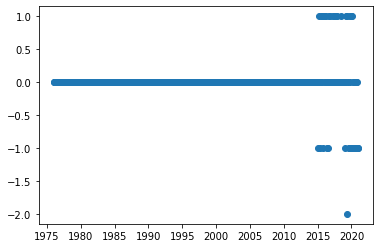

In [7]:
x = nl_production_monthly.index
y = nl_production_monthly.NetConsumptionCalculated_30
nl_production_monthly['ProductionGap'] =  nl_production_monthly['NetProductionTotal_3'] - nl_production_monthly['NetConsumptionCalculated_30'] + nl_production_monthly['ImportsTotal_17'] - nl_production_monthly['ExportsTotal_23'] - nl_production_monthly['DistributionLosses_29']
# "The total net consumption of electricity in the Netherlands is calculated as the net production plus imports minus exports and distribution losses."

plt.scatter(x, nl_production_monthly['ProductionGap'])

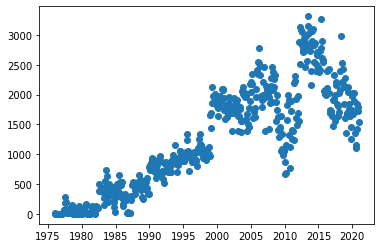

In [8]:
#nl_production_monthly.tail(20)

plt.scatter(x, nl_production_monthly['ImportsTotal_17'])

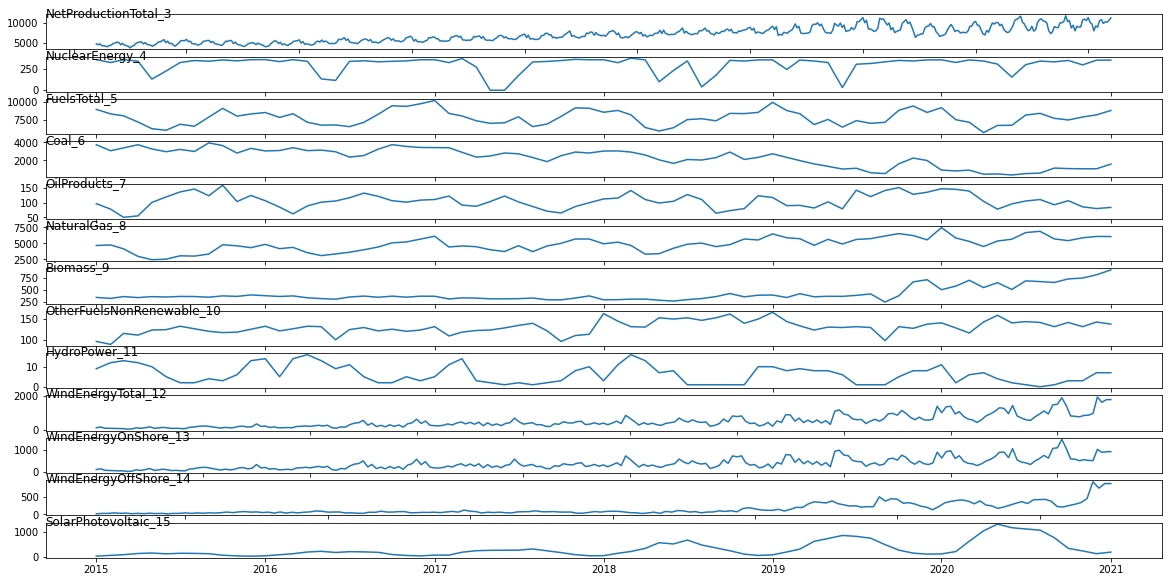

In [9]:
import matplotlib.pyplot as plt

x = nl_production_monthly.index


i = 1
cols=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(x, nl_production_monthly.values[:, col])
    plt.title(nl_production_monthly.columns[col], y=0.75, loc='left')
    i += 1
plt.show()

Text(0.0, 0.75, 'WindEnergyOffShore_14')

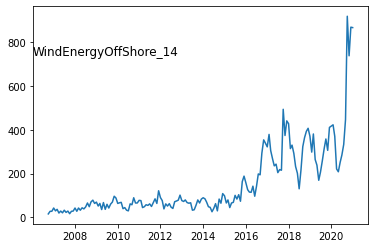

In [10]:
plt.plot(x, nl_production_monthly.values[:, 13])
plt.title(nl_production_monthly.columns[13], y=0.75, loc='left')

Text(0.0, 0.75, 'SolarPhotovoltaic_15')

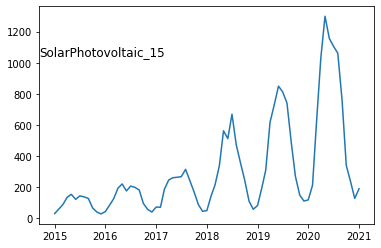

In [11]:
plt.plot(x, nl_production_monthly.values[:, 14])
plt.title(nl_production_monthly.columns[14], y=0.75, loc='left')

In [12]:
import plotly.graph_objs as go
from plotly.offline import iplot

def plot_dataset(df, title):
    data = []
    value = go.Scatter(
        x=df.index,
        y=df.value,
        mode="lines",
        name="values",
        marker=dict(),
        text=df.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    layout = dict(
        title=title,
        xaxis=dict(title="Date", ticklen=5, zeroline=False),
        yaxis=dict(title="Value", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)


#plot_dataset(nl_production_monthly, title='Energy Production Million kWh')

# Electricity Consumption Prediction using weather, population and economic output

In [13]:
#Import Electrcity Balance data (Predicted variable: NetConsumptionCalculated_30)
info = cbsodata.get_info('84575ENG')
print(info)

Electricity_balance = pd.DataFrame(cbsodata.get_data('84575ENG')) ##Consumer confidence, economic climate and willingness to buy

Electricity_balance[Electricity_balance['Periods'].str.contains('1979')]
##Monthly consumption data available from 1979 onwards

{'ID': 0, 'Title': 'Electricity balance sheet; supply and consumption', 'ShortTitle': 'Electricity; supply and consumption', 'Identifier': '84575ENG', 'Summary': 'Electricity, production by energy source, import, export and consumption\n ', 'Modified': '2021-04-30T02:00:00', 'ReasonDelivery': 'Update', 'ExplanatoryText': '', 'Language': 'en', 'Catalog': 'CBS', 'Frequency': 'Monthly', 'Period': '1929- February 2021', 'ShortDescription': '\nThis table shows the supply of electricity. Consumption of electricity is calculated from the supply variables. The supply of electricity primarily includes production plus imports minus exports. The majority of the electricity produced is supplied to the public electricity grid by, for example, power stations and wind turbines. A smaller part is generated by companies themselves for the benefit of their own business processes. For example, many greenhouse companies generate their own electricity for the lighting of their greenhouses. \n\nThe net prod

,ID,Periods,GrossProduction_1,OwnConsumptionForElectrProduction_2,NetProductionTotal_3,NuclearEnergy_4,FuelsTotal_5,Coal_6,OilProducts_7,NaturalGas_8,Biomass_9,OtherFuelsNonRenewable_10,HydroPower_11,WindEnergyTotal_12,WindEnergyOnShore_13,WindEnergyOffShore_14,SolarPhotovoltaic_15,OtherSources_16,ImportsTotal_17,Belgium_18,Denmark_19,Germany_20,UnitedKingdom_21,Norway_22,ExportsTotal_23,Belgium_24,Denmark_25,Germany_26,UnitedKingdom_27,Norway_28,DistributionLosses_29,NetConsumptionCalculated_30
98,98,1979 January,6124.0,248.0,5876.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,23,NaN,NaN,NaN,NaN,NaN,266.0,5591.0
99,99,1979 February,5358.0,220.0,5138.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,20,NaN,NaN,NaN,NaN,NaN,230.0,4889.0
100,100,1979 March,5728.0,231.0,5497.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,246.0,5256.0
101,101,1979 1st quarter,17210.0,699.0,16511.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,41,NaN,NaN,NaN,NaN,NaN,743.0,15735.0
102,102,1979 April,5095.0,212.0,4883.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN,219.0,4661.0
103,103,1979 May,5199.0,217.0,4982.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN,223.0,4744.0
104,104,1979 June,4776.0,211.0,4565.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,NaN,NaN,NaN,NaN,NaN,20,NaN,NaN,NaN,NaN,NaN,203.0,4353.0
105,105,1979 2nd quarter,15070.0,640.0,14430.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,NaN,NaN,NaN,NaN,NaN,48,NaN,NaN,NaN,NaN,NaN,645.0,13758.0
106,106,1979 July,4466.0,198.0,4268.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101,NaN,NaN,NaN,NaN,NaN,21,NaN,NaN,NaN,NaN,NaN,187.0,4161.0
107,107,1979 August,4845.0,204.0,4641.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,134,NaN,NaN,NaN,NaN,NaN,22,NaN,NaN,NaN,NaN,NaN,205.0,4548.0


In [14]:
#Input variable: Weather - KNMI data (source: https://www.kaggle.com/davidzaccai/knmi-19012020-historical-weather-data)
#Measurements taken from Station 260: De Bilt, Utrecht

url = "https://raw.githubusercontent.com/dsirtioglu/python/dsirtioglu-RR/KNMI_20200710.csv"

Weather = pd.read_csv(url)
Weather.tail(20) 
#TG: avarage daily temperature in 0.1 degrees celsius

#DDVEC: vector mean of wind direction
#FHVEC: vector mean wind speed in 0.1 m/s 
#FG: mean wind speed for a whole day in 0.1 m/s

#SQ: sunshine duration (in 0.1 hours)

#DR: duration of precipitation (in 0.1 hours)
#RH: sum of precipitation for one day (in 0.1 mm)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (2,3,4,5,6,7,8,13,15,16,18,19,20,21,22,23,25,26,28,30,35,36,37,38,39,40) have mixed types.Specify dtype option on import or set low_memory=False.



,STN,YYYYMMDD,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,FXXH,TG,TN,TNH,TX,TXH,T10N,T10NH,SQ,SP,Q,DR,RH,RHX,RHXH,PG,PX,PXH,PN,PNH,VVN,VVNH,VVX,VVXH,NG,UG,UX,UXH,UN,UNH,EV24
43636,260,20200621,208,25,35,50,10,10,3,100,11,186,106,4,245,12,70,6,89,53,2030,0,0,0,1,10191,10213,24,10178,14,61,2,82,8,5,69,97,2,48,12,36
43637,260,20200622,285,17,23,30,8,0,24,90,13,178,110,24,224,15,76,24,135,81,2565,0,0,0,1,10248,10262,12,10216,1,56,4,82,10,2,67,96,24,42,12,45
43638,260,20200623,29,7,19,40,18,0,1,60,9,197,94,4,267,16,64,6,153,91,2914,0,0,0,1,10251,10260,8,10239,18,9,1,82,21,1,64,98,1,42,16,53
43639,260,20200624,86,33,34,50,18,10,1,90,15,233,147,2,294,14,103,6,148,88,2900,0,0,0,1,10223,10240,1,10206,18,65,1,83,19,4,52,91,1,33,12,56
43640,260,20200625,108,39,40,60,13,30,2,130,13,240,170,4,294,16,139,6,151,90,2873,0,0,0,1,10177,10207,1,10141,24,75,3,83,1,1,55,73,24,40,13,56
43641,260,20200626,146,24,31,50,9,10,23,100,11,242,190,3,301,15,153,6,128,76,2817,36,34,16,22,10110,10139,1,10086,18,24,24,82,13,3,61,98,24,35,16,55
43642,260,20200627,214,35,36,60,15,10,1,150,19,206,175,21,248,12,162,24,58,35,1663,12,21,16,7,10086,10094,23,10077,17,12,1,83,18,7,79,98,1,60,13,31
43643,260,20200628,227,51,52,70,9,30,21,140,10,179,152,24,214,16,132,24,94,56,2132,3,1,1,4,10114,10125,14,10090,1,74,11,83,23,5,60,73,3,45,17,37
43644,260,20200629,225,56,58,70,11,40,2,150,20,160,133,4,190,17,118,6,44,26,1408,0,-1,-1,1,10103,10113,11,10087,24,70,24,83,1,7,62,76,5,48,17,24
43645,260,20200630,224,49,51,70,10,20,23,150,10,160,141,6,194,13,139,6,12,7,943,82,126,28,18,10076,10086,10,10063,24,29,19,81,13,8,82,97,24,61,13,16


In [15]:
Weather.dtypes

STN          int64
YYYYMMDD     int64
DDVEC       object
FHVEC       object
FG          object
FHX         object
FHXH        object
FHN         object
FHNH        object
FXX         object
FXXH        object
TG           int64
TN           int64
TNH         object
TX           int64
TXH         object
T10N        object
T10NH       object
SQ          object
SP          object
Q           object
DR          object
RH          object
RHX         object
RHXH        object
PG          object
PX          object
PXH         object
PN          object
PNH         object
VVN         object
VVNH        object
VVX         object
VVXH        object
NG          object
UG          object
UX          object
UXH         object
UN          object
UNH         object
EV24        object
dtype: object

In [16]:
#Create Datetime from YYYYMMDD

Weather['Date'] = pd.to_datetime(Weather['YYYYMMDD'].astype(int), format = '%Y%m%d')
Weather['Year'] = Weather['Date'].dt.year
Weather['Month'] = Weather['Date'].dt.month
Weather['Period'] = pd.PeriodIndex(Weather.Date, freq='Q')

Weather.head(10)

,STN,YYYYMMDD,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,FXXH,TG,TN,TNH,TX,TXH,T10N,T10NH,SQ,SP,Q,DR,RH,RHX,RHXH,PG,PX,PXH,PN,PNH,VVN,VVNH,VVX,VVXH,NG,UG,UX,UXH,UN,UNH,EV24,Date,Year,Month,Period
0,260,19010101,,,,,,,,,,-49,-65,,-24,,,,28,36,,,,,,,,,,,,,,,,66,,,,,,1901-01-01,1901,1,1901Q1
1,260,19010102,,,,,,,,,,-18,-33,,-14,,,,0,0,,,,,,,,,,,,,,,,86,,,,,,1901-01-02,1901,1,1901Q1
2,260,19010103,,,,,,,,,,-26,-76,,-6,,,,0,0,,,,,,,,,,,,,,,,89,,,,,,1901-01-03,1901,1,1901Q1
3,260,19010104,,,,,,,,,,-65,-90,,-11,,,,0,0,,,,,,,,,,,,,,,,79,,,,,,1901-01-04,1901,1,1901Q1
4,260,19010105,,,,,,,,,,-60,-82,,-20,,,,36,46,,,,,,,,,,,,,,,,65,,,,,,1901-01-05,1901,1,1901Q1
5,260,19010106,,,,,,,,,,-100,-114,,-80,,,,61,77,,,,,,,,,,,,,,,,63,,,,,,1901-01-06,1901,1,1901Q1
6,260,19010107,,,,,,,,,,-92,-121,,-68,,,,28,35,,,,,,,,,,,,,,,,71,,,,,,1901-01-07,1901,1,1901Q1
7,260,19010108,,,,,,,,,,-49,-93,,-7,,,,19,24,,,,,,,,,,,,,,,,79,,,,,,1901-01-08,1901,1,1901Q1
8,260,19010109,,,,,,,,,,11,-26,,44,,,,3,4,,,,,,,,,,,,,,,,76,,,,,,1901-01-09,1901,1,1901Q1
9,260,19010110,,,,,,,,,,15,-15,,61,,,,39,48,,,,,,,,,,,,,,,,82,,,,,,1901-01-10,1901,1,1901Q1


In [45]:
#Create the quarterly average weather dataset
Weather_Quarterly = Weather.groupby(['Period'], as_index = False).mean()
Weather_Quarterly = Weather_Quarterly[Weather_Quarterly['Period'] >= '1970Q1']
Weather_Quarterly

,Period,STN,YYYYMMDD,TG,TN,TX,Year,Month
276,1970Q1,260.0,1.970022e+07,15.722222,-14.733333,46.244444,1970.0,2.00000
277,1970Q2,260.0,1.970052e+07,122.736264,72.472527,170.670330,1970.0,5.00000
278,1970Q3,260.0,1.970081e+07,156.978261,109.521739,204.673913,1970.0,7.98913
279,1970Q4,260.0,1.970112e+07,68.923913,36.978261,99.467391,1970.0,11.00000
280,1971Q1,260.0,1.971022e+07,29.177778,-4.133333,59.566667,1971.0,2.00000
...,...,...,...,...,...,...,...,...
474,2019Q3,260.0,2.019081e+07,172.793478,117.336957,223.032609,2019.0,7.98913
475,2019Q4,260.0,2.019112e+07,79.391304,49.239130,109.760870,2019.0,11.00000
476,2020Q1,260.0,2.020022e+07,67.340659,34.516484,96.153846,2020.0,2.00000
477,2020Q2,260.0,2.020052e+07,138.945055,75.329670,195.329670,2020.0,5.00000


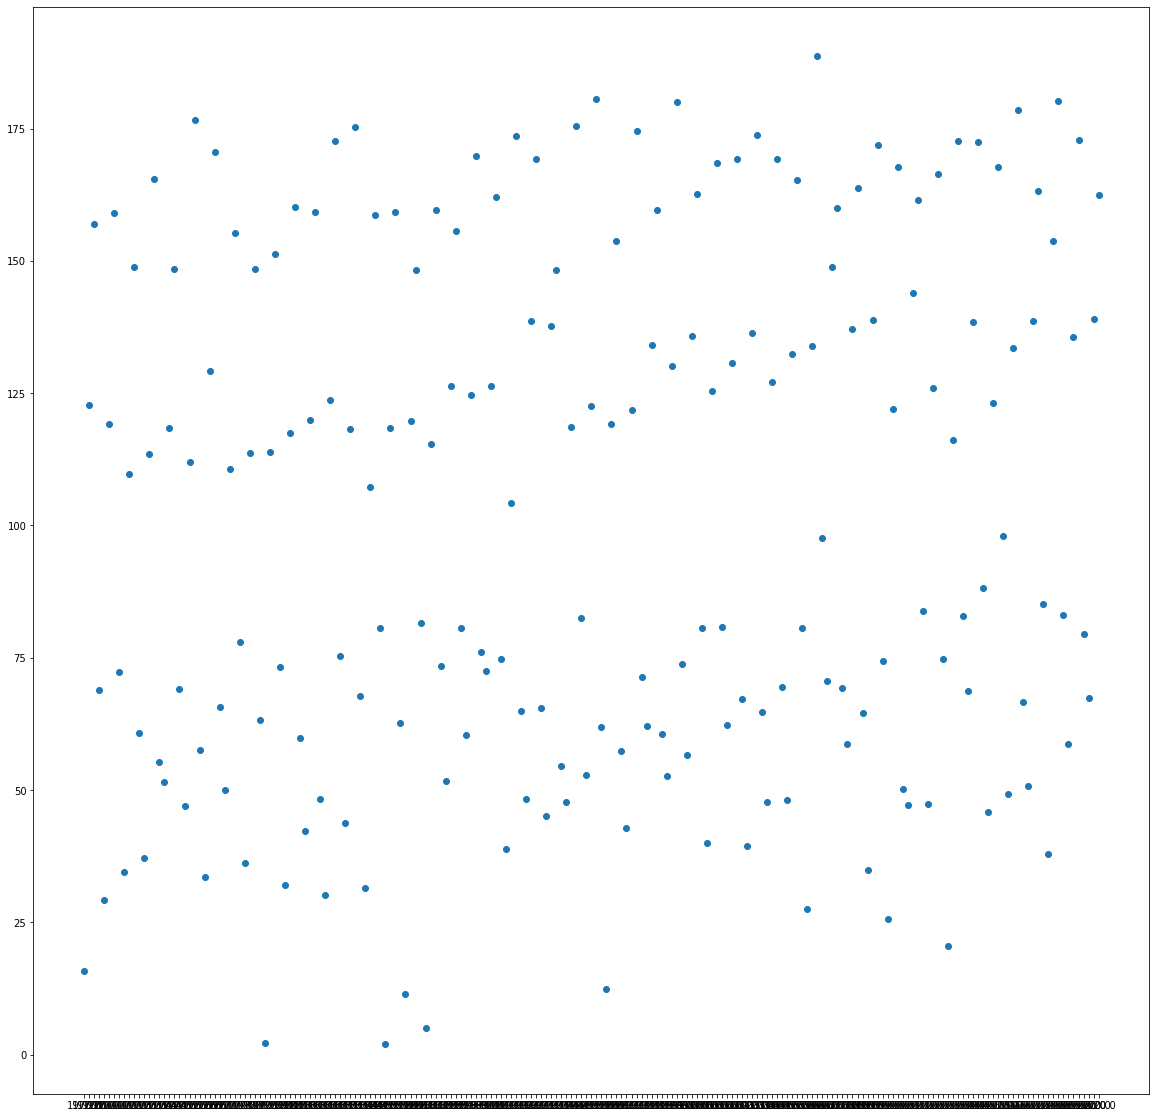

In [46]:
x = np.arange(0,len(Weather_Quarterly),1)
fig, ax = plt.subplots(1,1)
ax.scatter(x,Weather_Quarterly['TG'])
ax.set_xticks(x)
ax.set_xticklabels(Weather_Quarterly['Year'])
plt.gcf().set_size_inches((20, 20))
plt.show()

In [ ]:
#Input variable: Economic Output (source: https://data.oecd.org/gdp/quarterly-gdp.htm)
#Yearly and quarterly percentage changes, all countries

url = 'https://raw.githubusercontent.com/dsirtioglu/python/dsirtioglu-RR/Quarterly%20GDP.csv'

GDP = pd.read_csv(url)
GDP.head(20) 

##Filters to be applied: 

# LOCATION = NLD
# INDICATOR = 'QGDP'
# SUBJECT = 'TOT'
# MEASURE = 'PC_CHGPP'
# FREQUENCY = 'Q' -- For quarterly values
# Flag Codes = E (?)

#Note that 'Value' field indicate the percentage change from the previous quarter in GDP


In [ ]:
#Apply relevant filters

GDP_NL = GDP.loc[(GDP['LOCATION'] == 'NLD') & (GDP['INDICATOR'] == 'QGDP') & (GDP['SUBJECT'] == 'TOT') & (GDP['MEASURE'] == 'PC_CHGPP') & (GDP['FREQUENCY'] == 'Q')]
GDP_NL = GDP_NL.set_index('TIME')
GDP_NL

In [ ]:
x = GDP_NL.index
y = GDP_NL.Value

plt.scatter(x, y)
plt.gcf().set_size_inches((20, 20))
plt.show

In [ ]:
#Input variable: Population (source: https://data.oecd.org/pop/population.htm#indicator-chart)
#Population, all countries

url = 'https://raw.githubusercontent.com/dsirtioglu/python/main/World%20Population.csv'

POP = pd.read_csv(url)
POP.tail(20) 

##Filters to be applied: 

# LOCATION = NLD
# INDICATOR = 'POP'
# SUBJECT = 'TOT'
# MEASURE = 'MLN_PER' indicates million persons; 'AGRWTH' annual growth rate
# FREQUENCY = 'A' -- Only annual data available


In [ ]:
#Apply relevant filters

POP_NL = POP.loc[(POP['LOCATION'] == 'NLD') & (POP['INDICATOR'] == 'POP') & (POP['SUBJECT'] == 'TOT') & (POP['MEASURE'] == 'MLN_PER')]
POP_NL = POP_NL.set_index('TIME')
POP_NL

# What history tells you about post pandemic booms?

(https://www.economist.com/finance-and-economics/2021/04/29/what-history-tells-you-about-post-pandemic-booms)

###Import using cbsodata library (documentation: https://pypi.org/project/cbsodata/)


In [ ]:
tables = pd.DataFrame(cbsodata.get_table_list())
tables.head()

In [ ]:
info = cbsodata.get_info('83693ENG')
print(info)

In [ ]:
Confidence_data = pd.DataFrame(cbsodata.get_data('83693ENG')) ##Consumer confidence, economic climate and willingness to buy
Confidence_data.head()


In [ ]:
GDP_data = pd.DataFrame(cbsodata.get_data('84087ENG')) ##Approaches of domestic product (GDP); National Accounts
GDP_data.head()

In [ ]:
GDP_data = pd.DataFrame(cbsodata.get_data('84105ENG')) ##GDP, output and expenditures; value, Quarterly National Accounts
GDP_data.head()

In [ ]:
House_prices = pd.DataFrame(cbsodata.get_data('83625ENG')) ##Existing own homes; prices, region
House_prices.head()

In [ ]:
Rent_increase = pd.DataFrame(cbsodata.get_data('70675eng')) ##Consumer prices; rent increase for dwellings
Rent_increase.head()